In [1]:
#導入必要的包（使用python3.6）
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skew
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



color = sns.color_palette()
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
#讀取數據
data = pd.read_csv('diabetes.csv')

In [3]:
print (data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [5]:
print (data.describe())

       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count      768.000  768.000        768.000        768.000  768.000 768.000   
mean         3.845  120.895         69.105         20.536   79.799  31.993   
std          3.370   31.973         19.356         15.952  115.244   7.884   
min          0.000    0.000          0.000          0.000    0.000   0.000   
25%          1.000   99.000         62.000          0.000    0.000  27.300   
50%          3.000  117.000         72.000         23.000   30.500  32.000   
75%          6.000  140.250         80.000         32.000  127.250  36.600   
max         17.000  199.000        122.000         99.000  846.000  67.100   

       DiabetesPedigreeFunction     Age  Outcome  
count                   768.000 768.000  768.000  
mean                      0.472  33.241    0.349  
std                       0.331  11.760    0.477  
min                       0.078  21.000    0.000  
25%                       0.244  24.000   

In [6]:
#插補0值（按Outcome 分組求平均插入）
data.loc[(data["Glucose"]==0) & (data['Outcome']==0),'Glucose'] = data.groupby('Outcome').mean()["Glucose"][0]
data.loc[(data["Glucose"]==0) & (data['Outcome']==1),'Glucose'] = data.groupby('Outcome').mean()["Glucose"][1]


data.loc[(data["BloodPressure"]==0) & (data['Outcome']==0),'BloodPressure'] = data.groupby('Outcome').mean()["BloodPressure"][0]
data.loc[(data["BloodPressure"]==0) & (data['Outcome']==1),'BloodPressure'] = data.groupby('Outcome').mean()["BloodPressure"][1]



data.loc[(data["SkinThickness"]==0) & (data['Outcome']==0),'SkinThickness'] = data.groupby('Outcome').mean()["SkinThickness"][0]
data.loc[(data["SkinThickness"]==0) & (data['Outcome']==1),'SkinThickness'] = data.groupby('Outcome').mean()["SkinThickness"][1]



data.loc[(data["Insulin"]==0) & (data['Outcome']==0),'Insulin'] = data.groupby('Outcome').mean()["Insulin"][0]
data.loc[(data["Insulin"]==0) & (data['Outcome']==1),'Insulin'] = data.groupby('Outcome').mean()["Insulin"][1]

data.loc[(data["BMI"]==0) & (data['Outcome']==0),'BMI'] = data.groupby('Outcome').mean()["BMI"][0]
data.loc[(data["BMI"]==0) & (data['Outcome']==1),'BMI'] = data.groupby('Outcome').mean()["BMI"][1]

In [7]:
data['Insulin'] = np.log1p(data['Insulin'])

In [8]:
skewed_feats = data.drop('Outcome', axis = 1).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
DiabetesPedigreeFunction,1.916
SkinThickness,1.208
Age,1.127
Pregnancies,0.900
Insulin,0.769
BMI,0.603
Glucose,0.530
BloodPressure,0.169


In [9]:
skewness = skewness[abs(skewness) > 0.75]

In [10]:
from scipy.special import boxcox1p
from scipy.stats import boxcox
skewed_features = skewness.index
lam = 0.245
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)


# skewed_features = skewness.index
# rx=[]
# rl=[]
# for feat in skewed_features:
#     all_data[feat] = boxcox(all_data[feat]+0.00001,0.25)
#     #rx.append(x)
#     #rl.append(x)
print('ok')

ok


In [11]:
#取出y和x
y = data['Outcome'].values
X = data.drop('Outcome', axis = 1)

In [12]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,1.645,9.106,7.576,5.026,2.140,5.526,0.388,5.525
std,1.054,0.799,0.485,0.754,0.148,0.481,0.224,0.755
min,0.000,6.291,4.899,2.712,1.545,4.337,0.076,4.623
25%,0.755,8.555,7.268,4.490,2.044,5.192,0.224,4.899
50%,1.651,9.054,7.596,4.810,2.147,5.535,0.329,5.310
75%,2.493,9.663,7.897,5.532,2.211,5.844,0.516,6.117
max,4.205,10.866,9.188,8.532,2.657,7.399,1.435,7.933


In [13]:
#連續值分組，構建類別特征
ages = pd.cut(X["Age"],3,labels=[1,2,3]).astype(int)
BMI =pd.cut(X["BMI"],3,labels=[1,2,3]).astype(int)

In [14]:
Pregnancies =pd.cut(X["Pregnancies"],3,labels=[1,2,3,]).astype(int)

In [15]:
Glucose =pd.cut(X["Glucose"],3,labels=[1,2,3]).astype(int)
BloodPressure =pd.cut(X["BloodPressure"],3,labels=[1,2,3]).astype(int)
SkinThickness =pd.cut(X["SkinThickness"],3,labels=[1,2,3]).astype(int)
Insulin =pd.cut(X["Insulin"],3,labels=[1,2,3]).astype(int)
DiabetesPedigreeFunction =pd.cut(X["DiabetesPedigreeFunction"],3,labels=[1,2,3]).astype(int)

In [16]:
print(pd.value_counts(Pregnancies) )

1    349
2    295
3    124
Name: Pregnancies, dtype: int64


In [17]:
#對類別特征熱值碼
a1 = (OneHotEncoder(sparse=False).fit_transform(ages.values.reshape(-1, 1)))
b1 = (OneHotEncoder(sparse=False).fit_transform(BMI.values.reshape(-1, 1)))
c1 = (OneHotEncoder(sparse=False).fit_transform(Pregnancies.values.reshape(-1, 1)))
d1 = (OneHotEncoder(sparse=False).fit_transform(Glucose.values.reshape(-1, 1)))
e1 = (OneHotEncoder(sparse=False).fit_transform(BloodPressure.values.reshape(-1, 1)))
f1 = (OneHotEncoder(sparse=False).fit_transform(SkinThickness.values.reshape(-1, 1)))
g1 = (OneHotEncoder(sparse=False).fit_transform(Insulin.values.reshape(-1, 1)))
h1 = (OneHotEncoder(sparse=False).fit_transform(DiabetesPedigreeFunction.values.reshape(-1, 1)))

In [18]:
#數據插入
da= pd.DataFrame(columns=['a1','a2','a3',], data = a1)
db= pd.DataFrame(columns=['b1','b2','b3'], data = b1)
dc= pd.DataFrame(columns=['c1','c2','c3',], data = c1)
dd= pd.DataFrame(columns=['d1','d2','d3'], data = d1)
de= pd.DataFrame(columns=['e1','e2','e3'], data = e1)
df= pd.DataFrame(columns=['f1','f2','f3'], data = f1)
dg= pd.DataFrame(columns=['g1','g2','g3'], data = g1)
dh= pd.DataFrame(columns=['h1','h2','h3'], data = h1)

In [19]:
X = X.drop('Pregnancies', axis = 1)

In [20]:
# # 數據標準化
# # 初始化特征的標準化器
# ss_X = StandardScaler()

# # 分別對訓練和測試數據的特征進行標準化處理
# X = ss_X.fit_transform(X)

In [21]:
X = pd.DataFrame(X)
X['a1']=da['a1']
X['a2']=da['a2']
X['a3']=da['a3']
# X['a4']=da['a4']
# X['a5']=da['a5']
# X['b1']=db['b1']
# X['b2']=db['b2']
# X['b3']=db['b3']
X['c1']=dc['c1']
X['c2']=dc['c2']
X['c3']=dc['c3']
# X['c4']=dc['c4']
# X['c5']=dc['c5']
X['d1']=dd['d1']
X['d2']=dd['d2']
X['d3']=dd['d3']
X['e1']=de['e1']
X['e2']=de['e2']
X['e3']=de['e3']
X['f1']=df['f1']
X['f2']=df['f2']
X['f3']=df['f3']
X['g1']=dg['g1']
X['g2']=dg['g2']
X['g3']=dg['g3']
X['h1']=dh['h1']
X['h2']=dh['h2']
X['h3']=dh['h3']

In [22]:
#將數據分割訓練數據與測試數據

# 隨機采樣20%的數據構建測試樣本，其余作為訓練樣本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=64, test_size=0.2)

In [23]:
lr= LogisticRegression()
# 交叉驗證用於評估模型性能和進行參數調優（模型選擇）
#分類任務中交叉驗證缺省是采用StratifiedKFold

loss = cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_log_loss')
print( 'logloss of each fold is: ',-loss)
print('cv logloss is:', -loss.mean())

logloss of each fold is:  [0.34765499 0.44140864 0.39530787 0.43809458 0.43384186 0.38399272
 0.3810759  0.48887079 0.47926497 0.40938646]
cv logloss is: 0.419889879919719


In [24]:
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1,0.2, 1,1.01, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=10, scoring='neg_log_loss')
grid.fit(X_train,y_train)
print (grid.score(X_train,y_train))
print('**********************************************************************')
print(grid.best_score_)
print(grid.best_params_)
print('**********************************************************************')
print (grid.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,grid.predict(X_test), labels=[1, 0]) )
print(metrics.classification_report(y_test, grid.predict(X_test), labels=[1,0], digits=4))

# -0.4504121324054152
# **********************************************************************
# -0.4677866783874703


# -0.37088220392288845
# **********************************************************************
# -0.404740811110916
# {'C': 0.2, 'penalty': 'l1'}
# **********************************************************************

#0.235
# -0.3588714688015304
# **********************************************************************
# -0.3963762503074018
# {'C': 1.01, 'penalty': 'l2'}
# **********************************************************************
# -0.29012886304238433
# [[ 38  11]
#  [  5 100]]
#              precision    recall  f1-score   support

#           1     0.8837    0.7755    0.8261        49
#           0     0.9009    0.9524    0.9259       105

# avg / total     0.8954    0.8961    0.8942       154



#0.24
# #-0.3596243551216354
# **********************************************************************
# -0.3965795943063267
# {'C': 1.01, 'penalty': 'l1'}
# **********************************************************************
# -0.2951461481379703
# [[39 10]
#  [ 6 99]]
#              precision    recall  f1-score   support

#           1     0.8667    0.7959    0.8298        49
#           0     0.9083    0.9429    0.9252       105

# avg / total     0.8950    0.8961    0.8949       154

-0.3548260147479181
**********************************************************************
-0.3948343056411211
{'C': 10, 'penalty': 'l1'}
**********************************************************************
-0.29281385349997346
[[ 39  10]
 [  4 101]]
             precision    recall  f1-score   support

          1     0.9070    0.7959    0.8478        49
          0     0.9099    0.9619    0.9352       105

avg / total     0.9090    0.9091    0.9074       154



D:\TOOL\zwPython\py36\python-3.6.2.amd64\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\TOOL\zwPython\py36\python-3.6.2.amd64\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


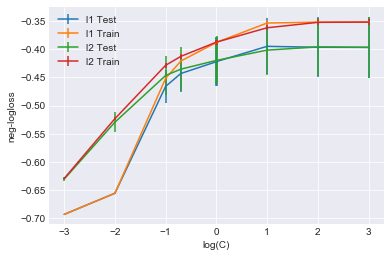

In [25]:
# plot CV誤差曲線
test_means = grid.cv_results_['mean_test_score']
test_stds = grid.cv_results_['std_test_score']
train_means = grid.cv_results_['mean_train_score']
train_stds = grid.cv_results_['std_train_score']

# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs, number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs, number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs, number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs, number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    # pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    plt.errorbar(x_axis, test_scores[:, i], yerr=test_stds[:, i], label=penaltys[i] + ' Test')
    plt.errorbar(x_axis, train_scores[:, i], yerr=train_stds[:, i], label=penaltys[i] + ' Train')

plt.legend()
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.savefig('LogisticGridSearchCV_C.png')

plt.show()

In [26]:
best_score_C_val=1.01      
LR_BestModel =LogisticRegression(penalty='l1',C=best_score_C_val, solver='liblinear',multi_class='ovr',
                           tol=1e-6,class_weight="balanced", random_state=64)

LR_BestModel.fit(X_train, y_train)
LR_PredictTest = LR_BestModel.predict(X_test)

print("訓練集上的accuracy_score為: {0:.4f}".format(metrics.accuracy_score(y_train, LR_BestModel.predict(X_train))))
print("訓練集上的recall_score為: {0:.4f}".format(metrics.recall_score(y_train, LR_BestModel.predict(X_train))))
print("")
print("預測集上的accuracy_score為: {0:.4f}".format(metrics.accuracy_score(y_test, LR_PredictTest)))
print("預測集上的recall_score為: {0:.4f}".format(metrics.recall_score(y_test, LR_PredictTest)))
print("")
print("混淆矩陣為:")
print(metrics.confusion_matrix(y_train, LR_BestModel.predict(X_train), labels=[1, 0]) )
print(metrics.confusion_matrix(y_test, LR_PredictTest, labels=[1, 0]) )
print("")
print("回歸參數報告:")
print(metrics.classification_report(y_train, LR_BestModel.predict(X_train), labels=[1,0], digits=4))  #digits：int，輸出浮點值的位數．
print(metrics.classification_report(y_test, LR_PredictTest, labels=[1,0], digits=4))  #digits：int，輸出浮點值的位數．

訓練集上的accuracy_score為: 0.8274
訓練集上的recall_score為: 0.8402

預測集上的accuracy_score為: 0.8506
預測集上的recall_score為: 0.8776

混淆矩陣為:
[[184  35]
 [ 71 324]]
[[43  6]
 [17 88]]

回歸參數報告:
             precision    recall  f1-score   support

          1     0.7216    0.8402    0.7764       219
          0     0.9025    0.8203    0.8594       395

avg / total     0.8380    0.8274    0.8298       614

             precision    recall  f1-score   support

          1     0.7167    0.8776    0.7890        49
          0     0.9362    0.8381    0.8844       105

avg / total     0.8663    0.8506    0.8541       154



In [27]:
SVC1 = LinearSVC().fit(X_train, y_train)

#在校驗集上測試，估計模型性能
y_predict = SVC1.predict(X_test)

y_train_predict = SVC1.predict(X_train)
print("Classification report for classifier %s:\n%s\n"
      % (SVC1, metrics.classification_report(y_train,y_train_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_train, y_train_predict))

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, metrics.classification_report(y_test, y_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.87      0.87      0.87       395
          1       0.77      0.77      0.77       219

avg / total       0.83      0.83      0.83       614


Confusion matrix:
[[344  51]
 [ 51 168]]
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.92      0.92      0.92       105
          1       0.84      0.84      0.84        49

avg / total       0.90      0.90      0.90       154


Confusion matrix:
[[9

accuracy: 0.8831168831168831
accuracy: 0.8896103896103896
accuracy: 0.9025974025974026
accuracy: 0.9090909090909091
accuracy: 0.8961038961038961
accuracy: 0.9025974025974026
accuracy: 0.9025974025974026
accuracy: 0.8896103896103896
accuracy: 0.9025974025974026
accuracy: 0.9025974025974026
accuracy: 0.9025974025974026
accuracy: 0.8701298701298701
accuracy: 0.8896103896103896
accuracy: 0.8896103896103896
accuracy: 0.8376623376623377
accuracy: 0.8766233766233766
accuracy: 0.8766233766233766
accuracy: 0.8311688311688312
accuracy: 0.8441558441558441
accuracy: 0.8376623376623377
accuracy: 0.8376623376623377
accuracy: 0.8831168831168831
accuracy: 0.8116883116883117
accuracy: 0.8636363636363636
accuracy: 0.9090909090909091
accuracy: 0.8376623376623377
accuracy: 0.8766233766233766
accuracy: 0.8961038961038961
accuracy: 0.8376623376623377
accuracy: 0.8246753246753247
accuracy: 0.9090909090909091
accuracy: 0.6168831168831169
accuracy: 0.8311688311688312
accuracy: 0.8636363636363636
accuracy: 0.88

No handles with labels found to put in legend.


accuracy: 0.4155844155844156
accuracy: 0.9025974025974026


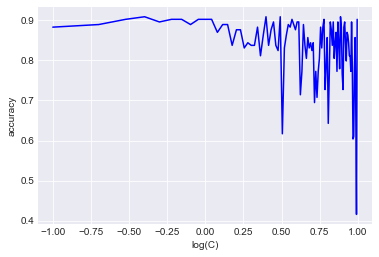

In [28]:
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    # 在訓練集是那個利用SVC訓練
    SVC2 = LinearSVC(C=C)
    SVC2 = SVC2.fit(X_train, y_train)

    # 在校驗集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    #print (SVC2.get_params) 0.003
    #print(dir(SVC2))
    print("accuracy: {}".format(accuracy))
    return accuracy



# C_s = [x/10000 for x in range(9000,10001)] #0.9-
C_s = [x/10 for x in range(1,100)]

# 需要調優的參數

accuracy_s = []
for i, oneC in enumerate(C_s):
    #for j, penalty in enumerate(penalty_s):
    tmp = fit_grid_point_Linear(oneC, X_train, y_train, X_test, y_test)
    accuracy_s.append(tmp)



x_axis = np.log10(C_s)
# for j, penalty in enumerate(penalty_s):
plt.plot(x_axis, np.array(accuracy_s), 'b-')

plt.legend()
plt.xlabel('log(C)')
plt.ylabel('accuracy')
plt.savefig('SVM_Otto.png')

plt.show()

In [29]:
#線性 SVM正則參數調優
#Cs = [x/10000.0 for x in range(1,101)]
CS =[ 0.0068]#最優
tuned_parameters = dict(penalty = ['l2','l1'], C = Cs)
SVC3=LinearSVC(dual=False)
grid= GridSearchCV(SVC3, tuned_parameters,cv=10, scoring='accuracy')
grid.fit(X_train,y_train)
print (grid.score(X_train,y_train))
#print (grid.score(X_test,y_test))

print('**********************************************************************')
print(grid.best_score_)
print(grid.best_params_)
print('**********************************************************************')

y_train_pred=grid.predict(X_train)

print("Classification report for classifier %s:\n%s\n"
      % (SVC3, metrics.classification_report(y_train, y_train_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_train, y_train_pred))
print('****************************************************************')


#在校驗集上測試，估計模型性能
y_predict = grid.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (SVC3, metrics.classification_report(y_test, y_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_predict))

0.8338762214983714
**********************************************************************
0.8306188925081434
{'C': 10, 'penalty': 'l2'}
**********************************************************************
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.87      0.88      0.87       395
          1       0.77      0.75      0.76       219

avg / total       0.83      0.83      0.83       614


Confusion matrix:
[[347  48]
 [ 54 165]]
****************************************************************
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_stat

In [30]:
# RBF核SVM正則參數調優

C_s = [c/10.0 for c in range(1,101) ]
#gamma_s = [g/1000.0 for g in range(1,101) ]
#C_s = [0.1]#最優
gamma_s=[0.17]
kernel_s=['rbf']
tuned_parameters = dict( C = C_s,gamma = gamma_s,kernel=kernel_s)
SVC4=SVC()
grid= GridSearchCV(SVC4, tuned_parameters,cv=5, scoring='accuracy')
# grid=grid.best_estimator_
grid.fit(X_train,y_train)
y_test_pred=grid.predict(X_test)
y_train_pred=grid.predict(X_train)

print("Classification report for classifier %s:\n%s\n"
      % (SVC4, metrics.classification_report(y_train, y_train_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_train, y_train_pred))
print('****************************************************************')


print("Classification report for classifier %s:\n%s\n"
      % (SVC4, metrics.classification_report(y_test, y_test_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_pred))
print('****************************************************************')
# print(grid.cv_results_)
print(grid.best_score_)
print(grid.best_params_)

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       395
          1       0.90      0.89      0.90       219

avg / total       0.93      0.93      0.93       614


Confusion matrix:
[[374  21]
 [ 24 195]]
****************************************************************
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.89      0.89      0.89       105
          1       0.76      0.78      0.77   